# 3.1 Data Preparation

In [230]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from collections import OrderedDict
import math
from datetime import date, timedelta

#third party imports
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import rcParams
import seaborn as sns

#local imports
import analysis.dataPreparer as dp
import analysis.autoVC2 as vc

In [231]:
#setup
%matplotlib inline

TINY_SIZE = 12
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,4)

save_path = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original/figures/design/"

In [232]:
pd.set_option('precision',3)

In [233]:
def auto_label(ax, fmt='{:,.0f}'):
    ymax_old = ax.get_ylim()[1]
    ax.set_ylim(ymax= ax.get_ylim()[1] * 1.1)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+p.get_width()/2.,
            y=np.nanmax([height,0]) + ymax_old * 0.02,
            s=fmt.format(np.nanmax([height,0])),
            ha="center")
    ax.yaxis.set_ticks([])

In [264]:
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [235]:
def add_vertical_line(ax, value, label, color, linestyle="dashed"):
    ax.axvline(value, linestyle=linestyle, color=color)
    x_bounds = ax.get_xlim()
    xy_pos = (((value-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01)
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [236]:
def add_horizontal_line(ax, value, label, color, linestyle="dashed"):
    ax.axhline(value, linestyle=linestyle, color=color)
    y_bounds = ax.get_ylim()
    xy_pos = (1.01,((value-y_bounds[0])/(y_bounds[1]-y_bounds[0])))
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [237]:
def add_boxplot_labels(ax, labels, color="black"):
    y_bounds = ax.get_ylim()
    for value, label in enumerate(labels):
        xy_pos = (1.01,((value-y_bounds[0] + 0.15)/(y_bounds[1]-y_bounds[0])))
        ax.annotate(s=label, xy =xy_pos, size=TINY_SIZE, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [238]:
#constants
input_path = path+"analysis/input/master.db"
flatten_config = path+"analysis/config/master_feature.sql"
raw_flat_file = path+"analysis/output/temp/raw.csv"
clean_flat_file = path+"analysis/output/temp/clean.csv"
output_path = path+"analysis/output/temp/output.db"
#output_path = path+"analysis/output/autoVC/8/test/2015-04-06/2017-04-03/label_clean.csv"

#dp.flatten_file(input_path, flatten_config, raw_flat_file, "feature")
#dp.clean_file(raw_flat_file, clean_flat_file)
#dp.load_file(output_path, clean_flat_file, "feature")
df = dp.export_dataframe(output_path, "feature")
df_backup = df.copy()

logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 308.62


In [91]:
#reload data from memory
df = df_backup

In [ ]:
df = df.sample(50000)

In [239]:
def get_results(build, stage):
    
    def split_date(x):
        return date(*map(int, x.split("-")))
    
    df = pd.read_pickle(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\{}\{}\log_results.pkl".format(build, stage))
    df = df.reset_index()
    try: df["Time"] = pd.to_numeric(df["mean_fit_time"],errors="coerce")
    except: print("Error: Time")
    try: df["Imputer"] = df["param_imputer__strategy"].map({"most_frequent": "Mode", "median": "Median", "mean": "Mean"})
    except: print("Error: Imputer")
    try: df["Transformer"] = df["param_transformer__func"].astype(str).map({"None":"None","<ufunc 'sqrt'>":"SQRT","<ufunc 'log1p'>": "Log1P"})
    except: print("Error: Transformer")
    try: df["Scaler"] = df['param_scaler'].apply(lambda x: str(x).split("(")[0])
    except: print("Error: Scaler")
    try: 
        df["param_extractor__n_components_bin_20"] = df["param_extractor__n_components"] // 20
        df["Extractor"]=df['param_extractor__n_components_bin_20'].map({0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"})
    except: print("Error: Extractor")
    try: 
        df["Classifier"] = df["Classifier"].apply(lambda x: str(x).split("(")[0])
        df["Classifier"]=df['Classifier'].map({"LogisticRegression": "Logistic Regression", "RandomForestClassifier":"Random Forest", "DecisionTreeClassifier": "Decision Tree", "GaussianNB": "Naive Bayes", "MLPClassifier": "Artificial Neural Network", "KNeighborsClassifier": "K-Nearest Neighbors", "CalibratedClassifierCV": "Support Vector Machine"})
    except: print("Error: Classifier")
    try:
        df["label_date"] = df["label_slice"]
        df["label_date_str"] = df["label_date"].astype(str)
        df["feature_date"] = df["feature_slice"]
        df["feature_date_str"] = df["feature_date"].astype(str)
        df["forecast_window"] =  df["label_date"] - df["feature_date"]
        df["forecast_window_months"] = df["forecast_window"].apply(lambda x: x.days // 30)
    except: print("Error: Dates")
    try:
        df["outcome_chance"] = df["outcome_extra_stage_bool"].ix[0].value_counts(normalize=True)[1]
    except: print("Error: Outcome")
    df["Params_str"] = df["Params"].astype(str)
    return df

In [240]:
stage_features = dict(
    Age = 'confidence_context_broader_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

In [241]:
def create_stages(df, **features):
    df2 = df.copy()
    df2["keys_company_stage"] = "Other"
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Closed"]] >= 1), "Closed", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Acquired"]] >= 1), "Acquired", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["IPO"]] >= 1), "IPO", df2["keys_company_stage"])
    df2["keys_company_stage_series-d+"] = df2[[features["SeriesD"],features["SeriesE"],features["SeriesF"],features["SeriesG"],features["SeriesH"]]].sum(axis=1)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2["keys_company_stage_series-d+"] >= 1), "Series D+", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesC"]] >= 1), "Series C", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesB"]] >= 1), "Series B", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesA"]] >= 1), "Series A", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["FundingRaised"]] >= 0), "Seed", df2["keys_company_stage"])
    age_new_cutoff = df2[features["Age"]][df2["keys_company_stage"] == "Seed"].quantile(0.75)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Age"]] <= age_new_cutoff), "Pre-Seed", df2["keys_company_stage"])
    group_stages = {"Other" : "Excluded", "Closed" : "Excluded", "IPO" : "Excluded", "Acquired" : "Excluded", "Pre-Seed" : "Included",
        "Seed" : "Included", "Series A" : "Included", "Series B" : "Included", "Series C" : "Included", "Series D+" : "Included"}
    df2["keys_company_stage_group"] = df2["keys_company_stage"].map(group_stages)
    ordinal_stages = {"Pre-Seed" : 1, "Seed" : 2, "Series A" : 3, "Series B" : 4, "Series C" : 5, "Series D+" : 6,"Other" : np.nan, "Closed" : -1, "IPO" : 7, "Acquired" : 8}
    df2["keys_company_stage_number"] = df2["keys_company_stage"].map(ordinal_stages)
    return df2[["keys_company_stage_group", "keys_company_stage","keys_company_stage_number"]]

In [242]:
stages = create_stages(df, **stage_features)
df = pd.concat([stages, df], axis=1)
print("Stages done.")

Stages done.


## 3.1.3 Preliminary Screening

In [243]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Other        206872
Pre-Seed     113915
Seed          52219
Acquired      26894
Series A       8654
IPO            5800
Series B       4657
Closed         3279
Series C       2231
Series D+      1413
Name: keys_company_stage, dtype: int64
Other        0.486
Pre-Seed     0.267
Seed         0.123
Acquired     0.063
Series A     0.020
IPO          0.014
Series B     0.011
Closed       0.008
Series C     0.005
Series D+    0.003
Name: keys_company_stage, dtype: float64
425934


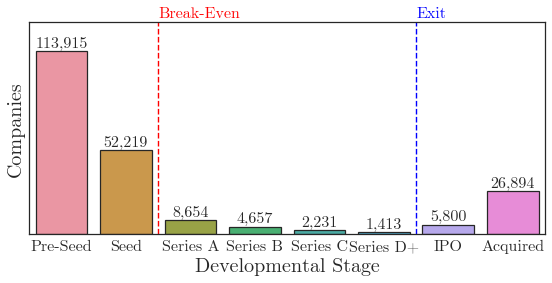

In [244]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired"]
f = plt.figure()
ax = sns.countplot(x= df["keys_company_stage"], order = order_1, **outline_bars)
auto_label(ax)
add_vertical_line(ax, 1.5, "Break-Even", color="r")
add_vertical_line(ax, 5.5, "Exit", color="b")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()
f.savefig(save_path+"lifecycle.pdf", bbox_inches="tight")

Removed Other, Closed, Acquired & IPO groups

In [245]:
df = df.loc[df['keys_company_stage_group'] != "Excluded"]

In [246]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Pre-Seed     113915
Seed          52219
Series A       8654
Series B       4657
Series C       2231
Series D+      1413
Name: keys_company_stage, dtype: int64
Pre-Seed     0.622
Seed         0.285
Series A     0.047
Series B     0.025
Series C     0.012
Series D+    0.008
Name: keys_company_stage, dtype: float64
183089


In [247]:
age_old_cutoff = df["confidence_context_broader_company_age_number"][df["keys_company_stage"] == "Series D+"].quantile(0.75)

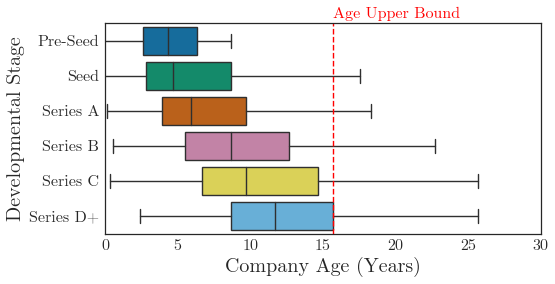

In [248]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
f = plt.figure()
ax = sns.boxplot(
    x="confidence_context_broader_company_age_number", 
    y="keys_company_stage",
    order=order_1,data=df, fliersize=0)
ax.set_xlim(xmin=0, xmax=30)
ax.set_xlabel("Company Age (Years)")
ax.set_ylabel("Developmental Stage")
add_vertical_line(ax, age_old_cutoff, "Age Upper Bound", color="r")
plt.tight_layout()
f.savefig(save_path+"stages_ages.pdf", bbox_inches="tight")

Removed companies older than 15 years old

In [249]:
age_old_cutoff

15.698630136986301

In [250]:
df = df.loc[df['confidence_context_broader_company_age_number'] <= age_old_cutoff]

In [251]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Pre-Seed     113915
Seed          38942
Series A       6615
Series B       3342
Series C       1610
Series D+       998
Name: keys_company_stage, dtype: int64
Pre-Seed     0.689
Seed         0.235
Series A     0.040
Series B     0.020
Series C     0.010
Series D+    0.006
Name: keys_company_stage, dtype: float64
165422


## 3.1.4 Descriptive Statistics

Table 3. Final test dataset counts grouped by lifecycle stage.

In [252]:
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
X = X.select_dtypes(['number'])

In [253]:
df["keys_missing_features"] = X.isnull().sum(axis=1)
len(list(df))

419

In [254]:
groups = [df["keys_company_stage"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Obs Age (Years)        Funding Raised (USD, millions)  \
                         N      Median    IQR                         Median   
keys_company_stage                                                             
Pre-Seed            113915       4.362  3.737                            NaN   
Seed                 38942       4.663  4.003                          0.250   
Series A              6615       5.693  5.005                          4.400   
Series B              3342       7.608  5.918                         14.891   
Series C              1610       8.696  5.523                         35.285   
Series D+              998       9.696  5.005                         74.385   

                           Funding Rounds (N)      Available Features (N)       
                       IQR             Median  IQR                 Median  IQR  
keys_company_stage                                                              
Pre-Seed               NaN                NaN  NaN                     33  127  
Seed                 1.295                1.0  1.0                    185  127  
Series A             7.906                2.0  2.0                    246  117  
Series B            22.032                3.0  2.0                    261   87  
Series C            45.881                3.0  2.0                    311   80  
Series D+           90.300                5.0  3.0                    324   69

In [255]:
groups = [df["keys_company_stage_group"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median), ("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]),
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Obs Age (Years)         \
                               N      Median    IQR   
keys_company_stage_group                              
Included                  165422       4.688  4.003   

                         Funding Raised (USD, millions)        \
                                                 Median   IQR   
keys_company_stage_group                                        
Included                                            NaN  3.97   

                         Funding Rounds (N)      Available Features (N)       
                                     Median  IQR                 Median  IQR  
keys_company_stage_group                                                      
Included                                1.0  1.0                     98  145

Table 3. Final test dataset counts grouped by company sector.

In [256]:
industries = [x for x in list(df) if x.startswith("confidence_context_industry_category_group_list")]

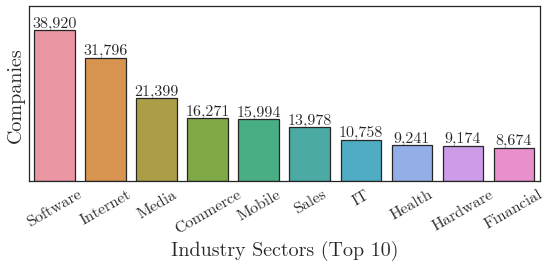

In [266]:
values = [df[industry].value_counts()[1] for industry in industries]
values = sorted(values,reverse=True)
f = plt.figure()
names = ["Software", "Internet", "Media", "Commerce", "Mobile", "Sales", "IT", "Health", "Hardware", "Financial"]
ax = sns.barplot(y = values, x = names, order = names,  **outline_bars)
auto_label(ax)
plt.xticks(rotation=30)
ax.set_ylabel("Companies")
ax.set_xlabel("Industry Sectors (Top 10)")
plt.tight_layout()
f.savefig(save_path+"industry_counts.pdf", bbox_inches="tight")

[SPARSITY]

In [258]:
missing_by_feature = X.isnull().sum(axis=1)

In [259]:
missing_by_col =  X.isnull().sum(axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


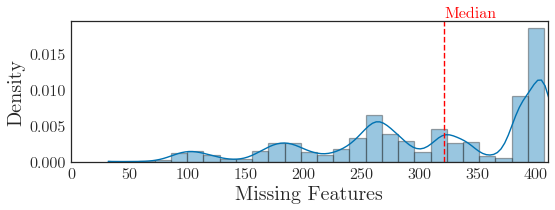

In [261]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(missing_by_feature, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_col))
add_vertical_line(ax, np.median(missing_by_feature), "Median", color="r")
ax.set_xlabel("Missing Features")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_features.pdf", bbox_inches="tight")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


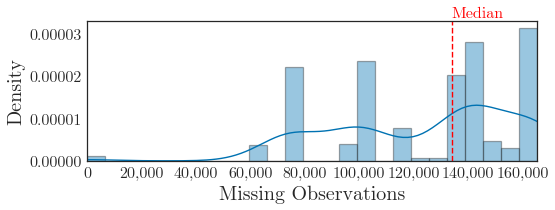

In [262]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(missing_by_col, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_feature))
add_vertical_line(ax, np.median(missing_by_col), "Median", color="r")
ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Missing Observations")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_observations.pdf", bbox_inches="tight")

[SKEW BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

In [267]:
skews = X.apply(lambda x: stats.skew(x.dropna())).dropna()
skews = skews[(skews >= -20) & (skews < 40)]

KeyboardInterrupt: 

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(skews, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-20, xmax=40)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
add_vertical_line(ax, 0, "Norm", color="b")
add_vertical_line(ax, np.median(skews), "Median", color="r")
ax.set_xlabel("Skew")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"skew.pdf", bbox_inches="tight")

In [ ]:
kurtoses = X.apply(lambda x: stats.kurtosis(x.dropna())).dropna()
kurtoses = kurtoses[(kurtoses >= -25) & (kurtoses < 200)]

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(kurtoses, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-25, xmax=200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
add_vertical_line(ax, 0, "Norm", color="b")
add_vertical_line(ax, np.median(kurtoses), "Median", color="r")
ax.set_xlabel("Kurtosis (Fisher's)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"kurtosis.pdf", bbox_inches="tight")

[KURTOSIS  BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

[BOXPLOT OF FEATURES]

In [ ]:
iqrs = X.apply(lambda x: stats.iqr(x.dropna())).dropna()
iqrs = np.log1p(iqrs)
iqrs = iqrs[(iqrs >= 0) & (iqrs < 25)]

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(iqrs, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
add_vertical_line(ax, np.mean(iqrs), "Mean", color="b")
add_vertical_line(ax, np.median(iqrs), "Median", color="r")
ax.set_xlabel("Interquartile Range (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"scaling.pdf", bbox_inches="tight")

[ORTHOGONALITY]

In [ ]:
X_sample = X.sample(1000)
thresholds = [x*.1 for x in range(10)]

In [ ]:
pearson = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="pearson").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
pearson = pd.DataFrame.from_dict(data=pearson, orient="index")
pearson["Method"] = "Pearson"

In [ ]:
kendall = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="kendall").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
kendall = pd.DataFrame.from_dict(data=kendall, orient="index")
kendall["Method"] = "kendall"

In [ ]:
spearman = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="spearman").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
spearman = pd.DataFrame.from_dict(data=spearman, orient="index")
spearman["Method"] = "Spearman"

In [ ]:
corrs = pd.concat([spearman, pearson], axis=0)
corrs = corrs.drop(0.0)

In [ ]:
f = plt.figure()
ax = sns.barplot(x=corrs.index, y=corrs[0], hue=corrs["Method"], **outline_bars)
auto_label(ax, fmt='{:,.0f}%')
ax.set_xlabel("Correlation Cutoff (abs)")
ax.set_ylabel("Intercorrelations\nabove Cutoff (%)")
plt.tight_layout()
f.savefig(save_path+"orthogonality.pdf", bbox_inches="tight")

# 3.2 Pre-Processing

## 3.2.1 Imputation

Figure 3. Mean, median and mode of features (grouped bar plot).

In [ ]:
means = X_sample.apply(lambda x: np.mean(x.dropna())).dropna()

In [ ]:
medians = X_sample.apply(lambda x: np.median(x.dropna())).dropna()

In [ ]:
def get_mode(x):
    try: return stats.mode(x.dropna())[0][0]
    except: return np.nan

modes = X.apply(get_mode).dropna()

In [ ]:
f = plt.figure()
plt.hist([means, medians, modes],label=["Mean","Median","Mode"], **outline_bars)
plt.xlabel("Measures of Central Tendency")
plt.ylabel("Features")
plt.legend(title="Method")
plt.tight_layout()
f.savefig(save_path+"central_tendency.pdf", bbox_inches="tight")

Figure 3. ROC Curve for different imputations - mean, median, mode (line plot).

In [ ]:
df_create = get_results(15, "create")

In [ ]:
f = plt.figure()
order = df_create.groupby("Imputer")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Imputer", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Imputer Strategy")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"imputer.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Transformer")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Transformer", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Transformation Function")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"transformer.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Scaler")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Scaler", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Scaling Function")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"scaler.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create['param_extractor__n_components_bin_20'].value_counts().index.sort_values().tolist()
order = list(map(lambda x: {0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"}[x], order))
ax = sns.boxplot(x="PRC", y="Extractor", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("PCA Extracted Components")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"extracter.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Classifier")["PRC"].quantile(0.75).sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Classifier", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Classification Algorithm")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"classifier.pdf", bbox_inches="tight")

In [167]:
df_create = get_results(16, "create")

In [173]:
df_create["ROC"] = df_create["ROC"].fillna(df_create['AUC'])

In [175]:
df_create["MCC"] = df_create["MCC"].fillna(df_create['MC'])

In [176]:
groups = [df_create["Classifier"]]
columns = ["PRC", "ROC", "F1", "MCC", "Time"]
colnames = ["AUC PRC", "AUC ROC", "F1", "MCC", "Fit Time (s)"]
colfuncs = [
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df_create[columns]
tab = tab.groupby(groups)
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

AUC PRC        AUC ROC            F1           MCC  \
                           Median    Max  Median    Max Median    Max Median   
Classifier                                                                     
Artificial Neural Network   0.320  0.335   0.517  0.523  0.072  0.096  0.111   
Decision Tree               0.388  0.429   0.651  0.659  0.305  0.314  0.212   
K-Nearest Neighbors         0.335  0.353   0.532  0.565  0.131  0.226  0.137   
Logistic Regression         0.417  0.465   0.675  0.710  0.339  0.358  0.255   
Naive Bayes                 0.354  0.367   0.623  0.638  0.303  0.321  0.212   
Random Forest               0.376  0.465   0.619  0.709  0.332  0.360  0.271   
Support Vector Machine      0.233  0.244   0.503  0.504  0.014  0.017  0.038   

                                 Fit Time (s)           
                             Max       Median      IQR  
Classifier                                              
Artificial Neural Network  0.140        9.146   12.017  
Decision Tree              0.224       15.329    6.747  
K-Nearest Neighbors        0.210        8.537   12.316  
Logistic Regression        0.288        7.326  407.031  
Naive Bayes                0.239        8.589   19.131  
Random Forest              0.288       68.325   29.064  
Support Vector Machine     0.045       29.015    0.000

In [177]:
tab.to_latex()

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n{} & AUC PRC &        & AUC ROC &        &     F1 &        &    MCC &        & Fit Time (s) &          \\\\\n{} &  Median &    Max &  Median &    Max & Median &    Max & Median &    Max &       Median &      IQR \\\\\nClassifier                &         &        &         &        &        &        &        &        &              &          \\\\\n\\midrule\nArtificial Neural Network &   0.320 &  0.335 &   0.517 &  0.523 &  0.072 &  0.096 &  0.111 &  0.140 &        9.146 &   12.017 \\\\\nDecision Tree             &   0.388 &  0.429 &   0.651 &  0.659 &  0.305 &  0.314 &  0.212 &  0.224 &       15.329 &    6.747 \\\\\nK-Nearest Neighbors       &   0.335 &  0.353 &   0.532 &  0.565 &  0.131 &  0.226 &  0.137 &  0.210 &        8.537 &   12.316 \\\\\nLogistic Regression       &   0.417 &  0.465 &   0.675 &  0.710 &  0.339 &  0.358 &  0.255 &  0.288 &        7.326 &  407.031 \\\\\nNaive Bayes               &   0.354 &  0.367 &   0.623 &  0.638 &  0

## 3.2.2 Transformation

--> Apply Imputation

In [178]:
from sklearn.preprocessing import Imputer

X = X.dropna(axis=1, how = "all")
imp = Imputer(strategy="median")
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, index=X.index, columns=list(X))

--> Shift to positive numbers only

In [179]:
mins_by_col = X_imp.min(axis=0)#.dropna()

In [180]:
X_pos = X_imp.subtract(X_imp.min(axis=0))
X_pos.describe()

,confidence_context_local_offices_headquarters_zipcode_number,confidence_context_industry_category_list_advertising,confidence_context_industry_category_list_apps,confidence_context_industry_category_list_consulting,confidence_context_industry_category_list_curated-web,confidence_context_industry_category_list_e-commerce,confidence_context_industry_category_list_health-care,confidence_context_industry_category_list_internet,confidence_context_industry_category_list_mobile,confidence_context_industry_category_list_social-media,...,potential_human_advisors_companies_exits_advisor_average_number,potential_human_advisors_companies_exits_advisor_total_number,potential_human_advisors_companies_acquisitions_advisor_average_number,potential_human_advisors_companies_acquisitions_advisor_total_number,potential_human_advisors_companies_ipo_advisor_average_number,potential_human_advisors_companies_ipo_advisor_total_number,potential_human_advisors_companies_operating_advisor_average_number,potential_human_advisors_companies_operating_advisor_total_number,potential_human_advisors_companies_closed_advisor_average_number,potential_human_advisors_companies_closed_advisor_total_number
count,1.654e+05,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,...,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000,165422.000
mean,1.640e+05,0.040,0.040,0.025,0.054,0.074,0.041,0.044,0.080,0.042,...,0.125,0.349,0.099,0.272,0.035,0.104,2.313,4.637,0.007,0.017
std,7.367e+06,0.195,0.196,0.156,0.226,0.262,0.198,0.205,0.272,0.201,...,0.789,2.480,0.651,1.964,0.287,0.929,1.611,4.673,0.080,0.180
min,0.000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,6.065e+04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,2.091,4.000,0.000,0.000
50%,6.065e+04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,2.091,4.000,0.000,0.000
75%,6.065e+04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,2.091,4.000,0.000,0.000
max,1.939e+09,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,36.000,99.000,32.000,78.000,12.000,58.000,49.000,294.000,4.000,7.000


--> Start transformations

In [181]:
funding = pd.to_numeric(X_pos["confidence_validation_funding_raised_value_total_number"],errors="coerce")

In [182]:
funding.shape

(165422,)

In [183]:
log1p = pd.DataFrame(np.log1p(funding), index=X_pos.index)

In [184]:
sqrt = pd.DataFrame(funding**(1/2), index=X_pos.index)

In [185]:
funding = funding.to_frame()
funding["Method"] = "None"
log1p["Method"] = "Log1P"
sqrt["Method"] = "SQRT"
transforms = pd.concat([funding,log1p,sqrt],axis=0)

In [207]:
transforms.groupby("Method").describe()

confidence_validation_funding_raised_value_total_number
Method                                                               
Log1P  count                                          1.654e+05      
       mean                                           1.264e+01      
       std                                            3.496e+00      
       min                                            0.000e+00      
       25%                                            1.330e+01      
       50%                                            1.330e+01      
       75%                                            1.330e+01      
       max                                            2.316e+01      
None   count                                          1.654e+05      
       mean                                           3.735e+06      
       std                                            5.217e+07      
       min                                            0.000e+00      
       25%                                            5.999e+05      
       50%                                            5.999e+05      
       75%                                            5.999e+05      
       max                                            1.146e+10      
SQRT   count                                          1.654e+05      
       mean                                           1.051e+03      
       std                                            1.622e+03      
       min                                            0.000e+00      
       25%                                            7.745e+02      
       50%                                            7.745e+02      
       75%                                            7.745e+02      
       max                                            1.070e+05

In [238]:
transforms = transforms.sample(1000)

In [239]:
funding = transforms["confidence_validation_funding_raised_value_total_number"]
funding.name = "Funding Raised"

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


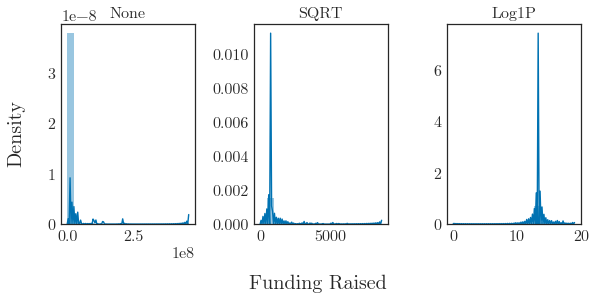

In [245]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

sns.distplot(funding[transforms["Method"] == "None"],ax=ax1)
ax1.set_title("None")
ax1.xaxis.label.set_visible(False)

sns.distplot(funding[transforms["Method"] == "SQRT"],ax=ax2)
ax2.set_title("SQRT")
ax2.xaxis.label.set_visible(False)

sns.distplot(funding[transforms["Method"] == "Log1P"],ax=ax3)
ax3.set_title("Log1P")
ax3.xaxis.label.set_visible(False)

f.text(0.5, -0.04, 'Funding Raised', size= MEDIUM_SIZE, ha='center')
f.text(-0.04, 0.5, 'Density', va='center', size= MEDIUM_SIZE, rotation='vertical')
plt.tight_layout()
f.savefig(save_path+"funding_transformation.pdf", bbox_inches="tight")

In [196]:
groups = "Method"
columns = "confidence_validation_funding_raised_value_total_number"
colnames = ["Funding Raised"]
colfuncs = [
    OrderedDict([
        ("Skew", lambda x: stats.skew(x,nan_policy="omit")),
        ("Kurtosis", lambda x: stats.kurtosis(x,nan_policy="omit")),
        #("Skew (0R)", lambda x: stats.skew(x.replace(0., np.nan),nan_policy="omit"))
        ("Kurtosis (0R)", lambda x: stats.kurtosis(x.replace(0., np.nan),nan_policy="omit"))
    ]
    ) 
]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["None", "Log1P", "SQRT"]

tab = transforms.groupby(groups)
tab = tab[columns]
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

Funding Raised                         
                 Skew   Kurtosis Kurtosis (0R)
Method                                        
Log1P          -2.853      8.063         6.767
None          123.470  22749.508     21319.112
SQRT           12.122    358.313       353.395

In [ ]:
tab = transforms.groupby(groups)
tab = tab[columns].replace(0, np.nan)
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

In [799]:
tab.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} & Funding Raised &            \\\\\n{} &           Skew &   Kurtosis \\\\\nMethod &                &            \\\\\n\\midrule\nLog1P  &         -2.853 &      8.063 \\\\\nNone   &        123.470 &  22749.508 \\\\\nSQRT   &         12.122 &    358.313 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [642]:
binary = pd.Series(np.where(funding == 0, 0, 1), index=X_pos.index)

--> Apply transformations

In [699]:
from sklearn.preprocessing import FunctionTransformer

ft = FunctionTransformer(np.log1p)
X_tf = ft.fit_transform(X_pos)
X_tf = pd.DataFrame(X_tf, index=X_pos.index, columns=list(X_pos))

--> Start scaling

--> Apply scaling

In [701]:
from sklearn.preprocessing import scale

X_std = scale(X_tf)
X_std = pd.DataFrame(X_std, index=X_tf.index, columns=list(X_tf))

## 3.2.3 Extraction

PCA Model

In [721]:
#Principal Components Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)

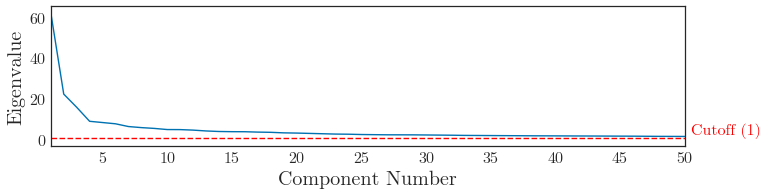

In [744]:
f = plt.figure(figsize=(10,3))
plt.plot(np.arange(len(y)) + 1, pca.explained_variance_)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylabel("Eigenvalue")
ax.set_xlabel("Component Number")
add_horizontal_line(ax, 1, "Cutoff (1)", color="r")
ax.set_xlim(1,50)
plt.tight_layout()
f.savefig(save_path+"scree_plot.pdf", bbox_inches="tight")

Grouped

In [ ]:
from collections import defaultdict
from itertools import combinations

features = list(X_std)
f_map = {x: '_'.join(x.split("_")[:3]) for x in features}
f_group = defaultdict(list)
for f,g in f_map.items():
    f_group[g].append(f)
agg_group = {}
for g,l in f_group.items():
    combo = combinations(l, 2)
    for x,y in combo:
        corr = stats.spearmanr(X_std[x][:100], X_std[y][:100])[0]
        if corr < 0: X_std[y] *= -1
    tot = X_std[l].sum(axis=1)
    agg_group[g] = tot
X_grp = pd.DataFrame(agg_group)
grp_corr = X_grp.corr(method="spearman")


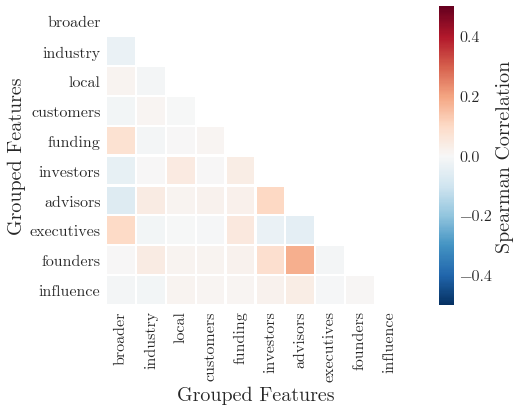

In [720]:
f = plt.figure()
mask = np.zeros_like(grp_corr)
mask[np.triu_indices_from(mask)] = True
f_names = [x.split("_")[2] for x in list(X_grp)]
ax = sns.heatmap(grp_corr,square=True, mask=mask, robust=True, vmin = -0.5, vmax = 0.5, xticklabels=f_names, yticklabels=f_names, **outline_bars)
ax.collections[0].colorbar.set_label("Spearman Correlation")
ax.set_xlabel("Grouped Features")
ax.set_ylabel("Grouped Features")
plt.tight_layout()
f.savefig(save_path+"grouped_heatmap.pdf", bbox_inches="tight")

# 3.3 Classification

# 3.4 Experimentation

## 3.4.2 Robustness

## 3.4.3 Predictive Power

Table 3.5 Comparison of 2013 slice from 2016 dataset with original 2013 dataset.

In [97]:
def plot_learning_curve(df, group, target, ax):
    
    def concat_lists(series):
        return np.array(list(zip(*[element for list_ in [np.array(list(zip(*list_))) for list_ in series] for element in list_])))

    test_scores = concat_lists(df.loc[df[group] == target]["Test_Scores"])
    train_scores = concat_lists(df.loc[df[group] == target]["Train_Scores"])
    train_sizes = df.loc[df[group] == target]["Train_Sizes"].sample(1).squeeze()
    print(train_sizes)
    
    ax.set_title("{}".format(target))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
            
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")
    a, = ax.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    b, = ax.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")        
    
    ax.grid()
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
    
    return (a,b)
    

In [114]:
def plot_learning_curves(df, group):
    targets = df[group].value_counts().index.tolist()
    rows=math.ceil(math.sqrt(len(targets)))
    cols = math.ceil(len(targets) / rows)
    f, axes = plt.subplots(nrows=rows, ncols=cols)
    axes = [item for sublist in axes for item in sublist]
    for i, target in enumerate(targets):
        leg = plot_learning_curve(df, group, target, axes[i])
        add_horizontal_line(axes[i], df["outcome_chance"].ix[0], "", color="r")
        if i == 0: axes[i].legend(
            bbox_to_anchor = axes[len(axes) - 1].get_position(),
            bbox_transform=plt.gcf().transFigure)
    for x in range(len(targets), len(axes)): f.delaxes(axes[x])
    f.text(0.5, -0.04, 'Training Examples', ha='center')
    f.text(-0.04, 0.5, 'Area under Precision-Recall Curve', va='center', rotation='vertical')
    plt.tight_layout()
    return f

In [104]:
df_create = get_results(16, "create")

In [111]:
df_create["outcome_chance"].ix[0]

0.10310943317078286

[ 3178  6356  9535 12713 15892 19070 22248 25427 28605 31784]
[ 3178  6357  9535 12714 15892 19071 22249 25428 28606 31785]
[ 3178  6356  9535 12713 15892 19070 22248 25427 28605 31784]
[ 3178  6357  9535 12714 15892 19071 22249 25428 28606 31785]
[ 3178  6356  9535 12713 15892 19070 22248 25427 28605 31784]
[ 3178  6357  9535 12714 15892 19071 22249 25428 28606 31785]
[ 3178  6357  9535 12714 15892 19071 22249 25428 28606 31785]


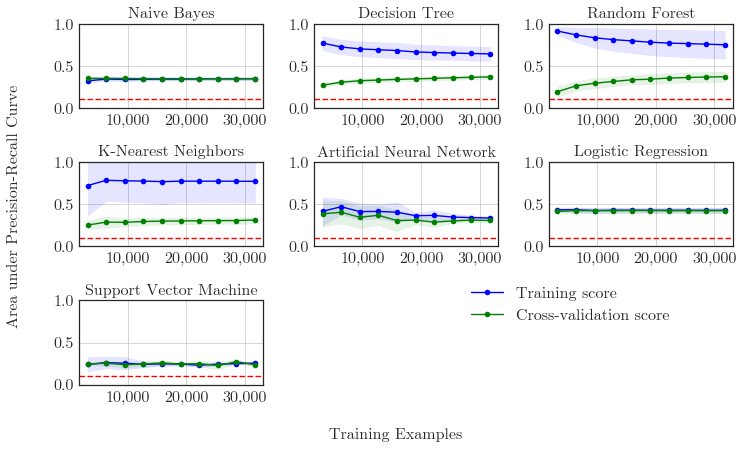

In [115]:
f = plot_learning_curves(df_create, "Classifier")
f.savefig(save_path+"create_learning_curves.pdf", bbox_inches="tight")

In [218]:
df_select = get_results(16, "select")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [226]:
df_select["feature_date_str"] = df_select["feature_date"].apply(lambda x: x.strftime("%Y-%m"))

In [227]:
df_select2 = df_select.copy()
df_select2["feature_date_str"] = "Overall"
df_select2 = pd.concat([df_select2, df_select],axis=0)

In [228]:
from datetime import date

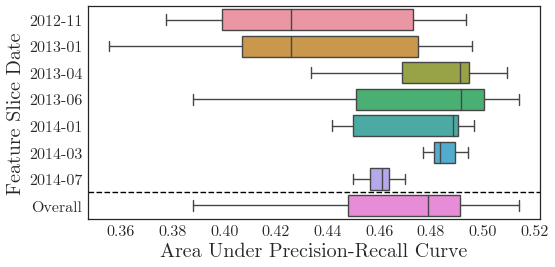

In [229]:
f = plt.figure()
order = df_select["feature_date_str"].value_counts().index.sort_values(ascending=True).tolist()
order.append("Overall")
ax = sns.boxplot(x="PRC", y="feature_date_str", data=df_select2, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Feature Slice Date")
#add_vertical_line(ax, df_select["outcome_chance"].median(), "Chance", color="r")
add_horizontal_line(ax, 6.5, "", color="black")
plt.tight_layout()
f.savefig(save_path+"selection_agg_slice.pdf", bbox_inches="tight")

In [273]:
df_select = get_results(16, "select")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [274]:
df_select3 = df_select[~np.isnan(df_select["rank_create"])]

In [275]:
labels = df_select3[["rank_create","Classifier"]].drop_duplicates().sort_values(by="rank_create", ascending=True)["Classifier"].tolist()

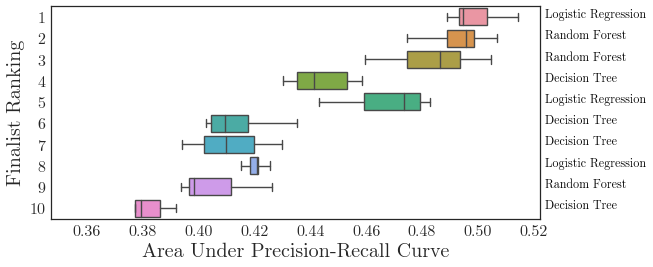

In [276]:
f = plt.figure()
order = df_select3["rank_create"].value_counts().index.tolist()
ax = sns.boxplot(x="PRC", y="rank_create", data=df_select3, order=order, fliersize=0, orient="h")
ax.set_yticklabels(["{:,.0f}".format(ytick+1) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Finalist Ranking")
add_boxplot_labels(ax, labels)
#add_vertical_line(ax, df_select3["outcome_chance"].median(), "Chance", color="r")
#add_horizontal_line(ax, 5.5, "", color="black")
plt.tight_layout()
f.savefig(save_path+"selection_agg_rank.pdf", bbox_inches="tight")

In [281]:
pipelines = get_results(16, "select")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [282]:
def rank_pipelines(pipelines, number_selected, criteria, stage):
    pipelines["Params_str"] = pipelines["Params"].astype(str)
    unique_params = {v:k for k,v in dict(enumerate(pipelines["Params_str"].unique().tolist())).items()}
    pipelines["Params_str_dummy"] = pipelines["Params_str"].replace(unique_params)
    dummy_rank = pipelines.groupby("Params_str_dummy")[criteria].median().rank(ascending=False).to_dict()
    pipelines["rank_{}".format(stage)] = pipelines["Params_str_dummy"].map(dummy_rank)
    pipelines.set_index("rank_{}".format(stage), drop=False, inplace=True)
    top_pipelines = pipelines.sort_index().ix[1:number_selected]
    top_pipelines = top_pipelines.drop_duplicates(subset="Params_str_dummy").squeeze()
    return top_pipelines

In [272]:
rank_pipelines(df_select3, 1, "PRC", "select")["Params"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

{'absolute': FunctionTransformer(accept_sparse=False, func=<ufunc 'absolute'>,
           inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
           validate=True),
 'absolute__accept_sparse': False,
 'absolute__func': <ufunc 'absolute'>,
 'absolute__inv_kw_args': None,
 'absolute__inverse_func': None,
 'absolute__kw_args': None,
 'absolute__pass_y': False,
 'absolute__validate': True,
 'clf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='entropy', max_depth=8, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=34, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__

In [283]:
best_pipeline = rank_pipelines(df_select3, 1, "PRC", "select")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

Pipeline Evaluation

Efficiency

Robustness

In [277]:
index=["People", "Companies", "Funding Rounds", "Acquisitions", "IPOs"]

sliced = pd.DataFrame({"Counts":[216146, 179351,49131,8882,790]}, index=index)
original = pd.DataFrame({"Counts": [226709, 196553,52928,9562,1259]},index=index)

sliced["Method"] = "Slice"
original["Method"] = "Original"
counts = pd.concat([sliced, original], axis=0)
 

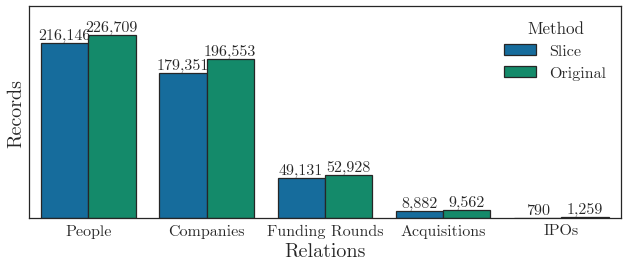

In [280]:
f = plt.figure(figsize=(9,4))
ax = sns.barplot(x=counts.index, y=counts["Counts"], hue=counts["Method"], **outline_bars)
auto_label(ax, fmt='{:,.0f}')
ax.set_xlabel("Relations")
ax.set_ylabel("Records")
plt.tight_layout()
f.savefig(save_path+"2013_slice_comparison.pdf", bbox_inches="tight")

In [184]:
#constants
input_path = path+"analysis/input/master.db"
feature_config = path+"analysis/config/master_feature.sql"
output_folder = path+"analysis/output/autoVC/17/"
slice_output_pickle = output_folder+"output.pkl"

In [1130]:
slices = [date(2012+x, 4, 1) for x in range(5)]
slice_counts = pd.DataFrame()
for slice_date in slices:
    df = vc.prepare_dataset(input_path, slice_date, feature_config, "feature", output_folder, alt=True)
    df = vc.add_stages(df)
    temp = pd.DataFrame()
    temp["id"] = df["keys_company_name_id"]
    temp["stage"] = df["keys_company_stage"]
    temp["group"] = df["keys_company_stage_group"]
    ages = df['confidence_context_broader_company_age_number']
    age_cutoff = ages[temp["stage"] == "Series D+"].quantile(0.75)
    temp["age_cutoff"] = np.where(ages <= age_cutoff, "Included", "Excluded")
    temp["date"] = slice_date
    slice_counts = pd.concat([temp, slice_counts], axis=0, ignore_index=True)
    slice_counts.to_pickle(output_pickle)

logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.32
logManager - INFO - prepare_dataset | Passed | 9.92
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 2.83
logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.26
logManager - INFO - prepare_dataset | Passed | 14.38
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 5.35
logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.31
logManager - INFO - prepare_dataset | Passed | 22.37
logManager - INFO - add_stages | Started
logManager - INFO - add_stages | Passed | 22.08
logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.35
logManager - INFO - prepare_dataset | Passed | 31

In [185]:
slice_counts= pd.read_pickle(slice_output_pickle)

In [186]:
list(slice_counts)

['id', 'stage', 'group', 'age_cutoff', 'date']

In [187]:
slice_counts["Slice"] = slice_counts["date"].apply(lambda x: x.year)

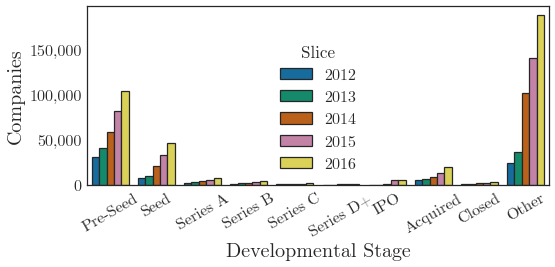

In [189]:
f = plt.figure()
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired", "Closed", "Other"]
order_2 = [2012, 2013, 2014, 2015, 2016]
ax = sns.countplot(x="stage", hue="Slice", order=order_1, hue_order=order_2, data=slice_counts, **outline_bars)
#auto_label(ax, fmt='{:,.0f}')
plt.xticks(rotation=30)
ax.set_yticklabels(["{:,.0f}".format(ytick) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()
#f.savefig(save_path+"slice_counts_over_time.pdf", bbox_inches="tight")

Predictive Power

In [5]:
#constants
input_path = path+"analysis/input/master.db"
feature_config = path+"analysis/config/master_feature.sql"
label_config = path+"analysis/config/master_label.sql"
merge_config = path+"analysis/config/master_merge.sql"
output_folder = path+"analysis/output/autoVC/17/"
merge_output_pickle = output_folder+"merge_output.pkl"

In [6]:
features_stage_info = dict(
    Age = 'confidence_context_broader_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

label_stage_info = dict(
    Age = 'outcome_age_number',
    FundingRounds = 'outcome_funding_rounds_number',
    FundingRaised = 'outcome_funding_raised_value_total_number',
    SeriesA = 'outcome_funding_round_codes_list_a',
    SeriesB = 'outcome_funding_round_codes_list_b',
    SeriesC = 'outcome_funding_round_codes_list_c',
    SeriesD = 'outcome_funding_round_codes_list_d',
    SeriesE = 'outcome_funding_round_codes_list_e',
    SeriesF = 'outcome_funding_round_codes_list_f',
    SeriesG = 'outcome_funding_round_codes_list_g',
    SeriesH = 'outcome_funding_round_codes_list_h',
    Closed = "outcome_closed_bool",
    Acquired = "outcome_acquired_bool",
    IPO = "outcome_ipo_bool"
)

In [18]:
from itertools import combinations_with_replacement
slices = [date(2012+x, 4, 1) for x in range(5)]
merge_counts = pd.DataFrame()
for feature_date, label_date in combinations_with_replacement(slices, 2):
    feature_clean_path = vc.prepare_dataset(input_path, feature_date, feature_config, "feature", output_folder)
    label_clean_path = vc.prepare_dataset(input_path, label_date, label_config, "label", output_folder)
    merge_path = vc.merge_datasets(feature_date, label_date, output_folder, feature_clean_path, label_clean_path, merge_config)
    df = dp.export_dataframe(merge_path, "merge")
    df = vc.add_stages(df, features_stage_info, "feature")
    df = vc.add_stages(df, label_stage_info, "label")
    df = vc.apply_constraints(df)
    y = vc.make_label(df)
    df = df["keys_company_name_id", "keys_company_uuid_id",
            "keys_company_stage", "outcome_stage",
            "keys_company_stage_number", "outcome_stage_number", 
            "outcome_extra_stage_number", "outcome_extra_stage_bool"]
    df["feature_date"] = feature_date
    df["label_date"] = label_date
    merge_counts = pd.concat([df, merge_counts], axis=0, ignore_index=True)
    merge_counts.to_pickle(merge_output_pickle)

logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.18
logManager - INFO - prepare_dataset | Passed | 0.19
logManager - INFO - prepare_dataset | Started
logManager - INFO - get_slice | Started
logManager - INFO - get_slice | Passed | 0.14
logManager - INFO - flatten_file | Started
logManager - INFO - flatten | Started
logManager - INFO - flatten | Passed | 6.63
dbLoader - INFO - C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/autoVC/17/2012-04-01_label_raw.csv | Already deleted
dbLoader - INFO - label.csv | Export started
dbLoader - INFO - label.csv | Export successful
logManager - INFO - flatten_file | Passed | 8.63
logManager - INFO - clean_file | Started
logManager - INFO - read | Started
logManager - INFO - read | Passed | 0.55
logManager - INFO - clean | Started
logManager - INFO - clean | Passed | 31.62
logManager - INFO - clean_file | Passed | 37.43
logManager - INFO - prepare_dataset

In [137]:
merge_counts= pd.read_pickle(merge_output_pickle)

In [138]:
merge_counts = merge_counts[[
    "keys_company_name_id", "keys_company_uuid_id",
    "keys_company_stage", "outcome_stage",
    "keys_company_stage_number", "outcome_stage_number", 
    "outcome_extra_stage_number", "outcome_extra_stage_bool",
    "feature_date", "label_date"]]

In [157]:
merge_counts["outcome_exit_bool"] = np.where((merge_counts["outcome_stage"] == "Acquisition") | (merge_counts["outcome_stage"] == "IPO"), 1, 0)

In [158]:
merge_counts2 = merge_counts[merge_counts["feature_date"] != merge_counts["label_date"]]

In [170]:
merge_counts3 = merge_counts2.groupby(['feature_date','keys_company_stage','label_date']).agg({'outcome_extra_stage_bool': lambda x: x.sum() / x.count() * 100})
merge_counts3 = merge_counts3.reset_index()
merge_counts3["forecast_window"] = merge_counts3["label_date"] - merge_counts3["feature_date"]
merge_counts3["forecast_window"] = merge_counts3["forecast_window"].apply(lambda x: x.days // 365).astype(str)

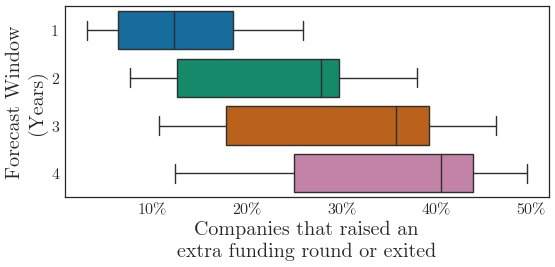

In [171]:
f = plt.figure()
ax = sns.boxplot(data = merge_counts3, x = "outcome_extra_stage_bool", y = "forecast_window", orient="h")
ax.set_xticklabels(["{:,.0f}%".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Companies that raised an\nextra funding round or exited")
ax.set_ylabel("Forecast Window\n(Years)")
plt.tight_layout()
f.savefig(save_path+"outcome_forecast_window.pdf", bbox_inches="tight")

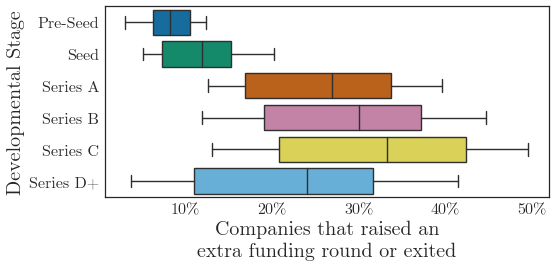

In [172]:
f = plt.figure()
ax = sns.boxplot(data = merge_counts3, x = "outcome_extra_stage_bool", y = "keys_company_stage", orient="h")
ax.set_xticklabels(["{:,.0f}%".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Companies that raised an\nextra funding round or exited")
ax.set_ylabel("Developmental Stage")
plt.tight_layout()
#f.savefig(save_path+"outcome_stage.pdf", bbox_inches="tight")

In [284]:
results = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [288]:
list(results)

['level_0',
 'index',
 'CK',
 'Classifier',
 'F1',
 'MCC',
 'PRC',
 'PRC_Thresholds',
 'Params',
 'Precision',
 'ROC',
 'ROC_FPR',
 'ROC_TPR',
 'ROC_Thresholds',
 'Recall',
 'Test_Scores',
 'Train_Scores',
 'Train_Sizes',
 'Weights',
 'feature_slice',
 'label_slice',
 'feature_names',
 'label_name',
 'feature_stage',
 'feature_stage_number',
 'label_stage',
 'label_stage_number',
 'outcome_extra_stage_bool',
 'rank_select',
 'build_identifier',
 'log_scores',
 'n_jobs',
 'verbosity',
 'master_path',
 'master_end_date',
 'master_start_date',
 'master_feature_config',
 'master_label_config',
 'master_merge_config',
 'output_folder',
 'create_pipelines_flag',
 'cv_folds_create',
 'time_slices_create',
 'max_observations_create',
 'load_prev_files_create',
 'output_folder_create',
 'output_slices_path_create',
 'output_log_create',
 'algorithms',
 'search_iterations',
 'select_pipeline_flag',
 'pipeline_criteria_select',
 'cv_folds_select',
 'time_slices_select',
 'max_observations_select'